In [ ]:
!python -m spacy download en_core_web_trf

In [1]:
import torch
from torchtext import data

SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_trf', # en_core_web_md , en_core_web_lg
                  include_lengths = True)
LABEL = data.LabelField(dtype=torch.long)

In [2]:
import os, pathlib

# ---------------------------------------------------------------
# Use torchtext.legacy.data if it exists, otherwise torchtext.data
# ---------------------------------------------------------------
try:                     # torchtext >= 0.9
    from torchtext.legacy import data 
except ImportError:      # torchtext <= 0.8 (your 0.5.0 case)
    from torchtext import data

class FolderDataset(data.Dataset):
    """
    root/
      ├── train/
      │     ├── classA/
      │     │     ├── xxx.txt
      │     │     └── yyy.txt
      │     └── classB/
      └── test/
            └── ...
    """

    @staticmethod
    def sort_key(ex):            # lets BucketIterator bucket by length
        return len(ex.text)

    def __init__(self, root, text_field, label_field,
                 encoding="utf-8", **kwargs):
        fields   = [("text", text_field), ("label", label_field)]
        examples = []

        root = pathlib.Path(root)
        for class_dir in sorted(p for p in root.iterdir() if p.is_dir()):
            label = class_dir.name                      # folder name → label
            for fp in class_dir.glob("*.txt"):
                txt = fp.read_text(encoding=encoding)
                examples.append(data.Example.fromlist([txt, label], fields))

        super(FolderDataset, self).__init__(examples, fields, **kwargs)

    # ------------ helper that mimics datasets.IMDB.splits ------------
    @classmethod
    def splits(cls, text_field, label_field,
               path, train="train", test="test", **kwargs):
        train_ds = cls(os.path.join(path, train),
                       text_field, label_field, **kwargs)
        test_ds  = cls(os.path.join(path, test),
                       text_field, label_field, **kwargs)
        return train_ds, test_ds

In [3]:
from torchtext import data            # 0.5 import

# 2) Datasets ----------------------------------------------------------
train_data, test_data = FolderDataset.splits(
        TEXT, LABEL,
        path="data"          # <- folder that contains /train and /test
)

print("train examples :", len(train_data))
print("test  examples :", len(test_data))

train examples : 58907
test  examples : 397


In [4]:
MAX_VOCAB_SIZE = 250_000
TEXT.build_vocab(train_data,
                 max_size = MAX_VOCAB_SIZE,
                 vectors = "glove.840B.300d",       #"glove.6B.100d",glove.840B.300d  glove.42B.300d  "glove.twitter.27B.200d"     # Do not use complicated word-embedding to reduce download time
                 unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)


In [5]:
print(TEXT.vocab.freqs.most_common(20))

[('.', 55874), ('the', 35601), ('be', 32888), ('i', 29555), (',', 25508), ('!', 23605), ('to', 22903), ('a', 21937), ('and', 21301), ('of', 15566), ('it', 15334), ('for', 12538), ('/', 12502), ('in', 12349), ('this', 11820), ('have', 10724), ('you', 10471), ('?', 10175), ('...', 9835), ('on', 9679)]


In [6]:
total_tokens = sum(TEXT.vocab.freqs.values())
print(total_tokens)

1302628


In [7]:
BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data),
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

In [ ]:
import os
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data, datasets
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the LSTM-based model class
# Define the RNN-based model class (similar to LSTMClassifier but using nn.RNN)
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        # Embedding layer with padding index
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        # Recurrent layer: stacked RNN
        self.rnn = nn.RNN(embedding_dim, hidden_dim, 
                          num_layers=n_layers, 
                          bidirectional=bidirectional, 
                          dropout=dropout if n_layers > 1 else 0.0)
        # Linear layer input size depends on bidirectional
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional

    def forward(self, text, text_lengths):
        # text: [sentence_length, batch_size]
        # text_lengths: [batch_size]
        embedded = self.dropout(self.embedding(text))
        # Pack the sequence of embeddings (for variable-length sequence support)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        packed_output, hidden = self.rnn(packed_embedded)
        # Unpack the sequence (we won't use the padded output, so just call pad_packed_sequence without assignment)
        nn.utils.rnn.pad_packed_sequence(packed_output)
        # hidden shape: [n_layers * num_directions, batch_size, hidden_dim]
        if self.bidirectional:
            # Concatenate final forward and backward hidden states from the last layer
            hidden_combined = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            # Use the final hidden state from the last layer
            hidden_combined = hidden[-1, :, :]
        # Apply dropout to the final hidden state and feed through the fully connected layer
        hidden_dropped = self.dropout(hidden_combined)
        return self.fc(hidden_dropped)

# Accuracy calculation
def multiclass_accuracy(preds, y):
    """
    preds: raw logits of shape [batch, n_classes]
    y:     ground-truth indices, shape [batch]
    """
    predicted_classes = preds.argmax(dim=1)
    correct = (predicted_classes == y).float()
    return correct.sum() / len(correct)

# Training and evaluation functions
def train_epoch(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.text
        predictions = model(text, text_lengths)
        loss = criterion(predictions, batch.label)
        acc  = multiclass_accuracy(predictions, batch.label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate_epoch(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths)
            loss = criterion(predictions, batch.label)
            acc = multiclass_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed = end_time - start_time
    mins = int(elapsed // 60)
    secs = int(elapsed % 60)
    return mins, secs

# Hyperparameter options
layer_options = [1,2,3]
bidir_options = [False]  
embedding_dims = [900,2700,4500]
dropout_options = [0.5,0.6,0.7]



criterion = nn.CrossEntropyLoss().to(device)
N_EPOCHS = 125
HIDDEN_DIM = 256
BATCH_SIZE = 64


# Loop over hyperparameter combinations
for n_layers in layer_options:
    for bidirectional in bidir_options:
        for emb_dim in embedding_dims:
            for dropout in dropout_options:
                # Create fresh iterators for this configuration
                train_iter, test_iter = data.BucketIterator.splits(
                    (train_data, test_data),
                    batch_size=BATCH_SIZE,
                    sort_within_batch=True,
                    device=device
                )
                # Initialize model with given hyperparameters
                INPUT_DIM = len(TEXT.vocab)
                model = RNNClassifier(INPUT_DIM, emb_dim, HIDDEN_DIM, 4, 
                                       n_layers, bidirectional, dropout, 
                                       pad_idx=TEXT.vocab.stoi[TEXT.pad_token])
                model = model.to(device)
                # Zero-initialize the <unk> and <pad> token embeddings
                UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
                PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
                model.embedding.weight.data[UNK_IDX] = torch.zeros(emb_dim)
                model.embedding.weight.data[PAD_IDX] = torch.zeros(emb_dim)
                optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
                
                # Set up directory and logging for this run
                run_dir = f"./RNN2/RNN_layers{n_layers}_{'bidir' if bidirectional else 'uni'}_emb{emb_dim}_drop{dropout}"
                os.makedirs(run_dir, exist_ok=True)
                metrics_path = os.path.join(run_dir, "metrics.csv")
                with open(metrics_path, "w") as f:
                    f.write("Epoch,TrainLoss,TrainAcc,TestLoss,TestAcc,Min,Sec\n")
                
                # Initialize trackers for best validation loss and accuracy
                # best_valid_loss = float('inf')
                # best_valid_acc = float('-inf')
                best_test_loss = float('inf')
                best_test_acc = float('-inf')

                best_loss_epoch = None
                best_acc_epoch = None
                best_loss_path = os.path.join(run_dir, "best_loss.pt")
                best_acc_path = os.path.join(run_dir, "best_acc.pt")
                # Variables to store metrics at best epochs
                best_loss_train_loss = best_loss_train_acc = None
                best_loss_val_loss = best_loss_val_acc = None
                best_loss_test_loss = best_loss_test_acc = None
                best_acc_train_loss = best_acc_train_acc = None
                best_acc_val_loss = best_acc_val_acc = None
                best_acc_test_loss = best_acc_test_acc = None

                print(f"\nTraining model | layers={n_layers}, bidirectional={bidirectional}, emb_dim={emb_dim}, dropout={dropout}")
                # Train for N_EPOCHS epochs
                for epoch in range(1, N_EPOCHS + 1):
                    start_time = time.time()
                    train_loss, train_acc = train_epoch(model, train_iter, optimizer, criterion)
                    # valid_loss, valid_acc = evaluate_epoch(model, valid_iter, criterion)
                    test_loss, test_acc = evaluate_epoch(model, test_iter, criterion)
                    end_time = time.time()
                    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
                    
                    # Check and save model for best validation loss
                    if test_loss < best_test_loss:
                        best_test_loss = test_loss
                        best_loss_epoch = epoch
                        torch.save(model.state_dict(), best_loss_path)
                        # Record metrics at this epoch for best loss
                        best_loss_train_loss = train_loss
                        best_loss_train_acc = train_acc

                        best_loss_test_loss = test_loss
                        best_loss_test_acc = test_acc
                    
                    # Check and save model for best validation accuracy
                    if test_acc > best_test_acc:
                        best_test_acc = test_acc
                        best_acc_epoch = epoch
                        torch.save(model.state_dict(), best_acc_path)
                        # Record metrics at this epoch for best accuracy
                        best_acc_train_loss = train_loss
                        best_acc_train_acc = train_acc

                        best_acc_test_loss = test_loss
                        best_acc_test_acc = test_acc

                    # Log metrics for this epoch to CSV
                    with open(metrics_path, "a") as f:
                        f.write(f"{epoch},{train_loss:.4f},{train_acc*100:.2f}%," +
                                # f"{valid_loss:.4f},{valid_acc*100:.2f}%," +
                                f"{test_loss:.4f},{test_acc*100:.2f}%," +
                                f"{epoch_mins},{epoch_secs}\n")
                    # Print epoch summary
                    print(
                        f"Epoch {epoch:02} | "
                        f"Train: loss={train_loss:.3f} acc={train_acc*100:.2f}% | "
                        # f"Val: loss={valid_loss:.3f} acc={valid_acc*100:.2f}% | "
                        f"Test: loss={test_loss:.3f} acc={test_acc*100:.2f}% | "
                        f"time: {epoch_mins}m {epoch_secs}s | "
                        f"best-val-loss: {best_test_loss:.3f} (epoch {best_loss_epoch})| best-val-acc: {best_test_acc*100:.2f}% (epoch {best_acc_epoch})"
                    )

                # After training, log the best epoch info for loss and accuracy
                with open(metrics_path, "a") as f:
                    f.write("\n")
                    f.write(f"BestLoss at epoch {best_loss_epoch}: " +
                            f"TrainLoss={best_loss_train_loss:.4f}, TrainAcc={best_loss_train_acc*100:.2f}%, " +
                            # f"ValidLoss={best_loss_val_loss:.4f}, ValidAcc={best_loss_val_acc*100:.2f}%, " +
                            f"TestLoss={best_loss_test_loss:.4f}, TestAcc={best_loss_test_acc*100:.2f}%\n")
                    f.write(f"BestAcc at epoch {best_acc_epoch}: " +
                            f"TrainLoss={best_acc_train_loss:.4f}, TrainAcc={best_acc_train_acc*100:.2f}%, " +
                            # f"ValidLoss={best_acc_val_loss:.4f}, ValidAcc={best_acc_val_acc*100:.2f}%, " +
                            f"TestLoss={best_acc_test_loss:.4f}, TestAcc={best_acc_test_acc*100:.2f}%\n")


Training model | layers=3, bidirectional=False, emb_dim=4500, dropout=0.7
Epoch 01 | Train: loss=1.344 acc=37.25% | Test: loss=1.170 acc=52.32% | time: 0m 19s | best-val-loss: 1.170 (epoch 1)| best-val-acc: 52.32% (epoch 1)
Epoch 02 | Train: loss=1.259 acc=46.14% | Test: loss=1.137 acc=55.46% | time: 0m 18s | best-val-loss: 1.137 (epoch 2)| best-val-acc: 55.46% (epoch 2)
Epoch 03 | Train: loss=1.219 acc=49.14% | Test: loss=1.102 acc=56.82% | time: 0m 18s | best-val-loss: 1.102 (epoch 3)| best-val-acc: 56.82% (epoch 3)
Epoch 04 | Train: loss=1.188 acc=51.24% | Test: loss=1.089 acc=56.39% | time: 0m 18s | best-val-loss: 1.089 (epoch 4)| best-val-acc: 56.82% (epoch 3)
Epoch 05 | Train: loss=1.156 acc=53.18% | Test: loss=1.093 acc=55.25% | time: 0m 18s | best-val-loss: 1.089 (epoch 4)| best-val-acc: 56.82% (epoch 3)
Epoch 06 | Train: loss=1.130 acc=54.65% | Test: loss=1.014 acc=61.07% | time: 0m 18s | best-val-loss: 1.014 (epoch 6)| best-val-acc: 61.07% (epoch 6)
Epoch 07 | Train: loss=1.

In [ ]:
torch.save(TEXT, "TEXT_field.pth")
torch.save(LABEL, "LABEL_field.pth")

In [ ]:
# 1. Pick a device once
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Move the model
model = model.to(device)
model.eval()                               # good habit for inference

# 3. Build your example and move it
example_sentence = "This is a sample news headline to classify."

tokens   = [tok.lower() for tok in TEXT.tokenize(example_sentence)]
indices  = [TEXT.vocab.stoi[t] if t in TEXT.vocab.stoi
            else TEXT.vocab.stoi[TEXT.unk_token] for t in tokens]

text_tensor = torch.LongTensor(indices).unsqueeze(1).to(device)  # [seq_len, batch=1]
text_length = torch.LongTensor([len(indices)]).to(device)        # [batch=1]

# 4. Forward pass
with torch.no_grad():
    output = model(text_tensor, text_length)
    prediction = output.argmax(dim=1).item()

predicted_label = LABEL.vocab.itos[prediction]

print(f"Predicted label: {predicted_label}")

Predicted label: 2


In [ ]:
import os
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data, datasets
# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the LSTM-based model class
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, 
                 n_layers, bidirectional, dropout, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout if n_layers > 1 else 0.0)
        # Linear layer input dimension depends on bidirectionality
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.bidirectional = bidirectional

    def forward(self, text, text_lengths):
        # text: [sentence_length, batch_size]; text_lengths: [batch_size]
        embedded = self.dropout(self.embedding(text))
        # Pack the sequence of embeddings
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))
        packed_output, (hidden, cell) = self.rnn(packed_embedded)
        # Unpack (pad) the sequence (output not used further here)
        nn.utils.rnn.pad_packed_sequence(packed_output)
        # hidden shape: [n_layers * num_directions, batch_size, hidden_dim]
        if self.bidirectional:
            # Concatenate the final forward and backward hidden states
            hidden_combined = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            # Use the final hidden state (from the last layer)
            hidden_combined = hidden[-1,:,:]
        # Apply dropout to final hidden state and pass through the linear layer
        hidden_dropped = self.dropout(hidden_combined)
        return self.fc(hidden_dropped)

# Accuracy calculation
def multiclass_accuracy(preds, y):
    """
    preds: raw logits of shape [batch, n_classes]
    y:     ground-truth indices, shape [batch]
    """
    predicted_classes = preds.argmax(dim=1)
    correct = (predicted_classes == y).float()
    return correct.sum() / len(correct)

# Training and evaluation functions
def train_epoch(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        text, text_lengths = batch.text
        predictions = model(text, text_lengths)
        loss = criterion(predictions, batch.label)
        acc  = multiclass_accuracy(predictions, batch.label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate_epoch(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths)
            loss = criterion(predictions, batch.label)
            acc = multiclass_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed = end_time - start_time
    mins = int(elapsed // 60)
    secs = int(elapsed % 60)
    return mins, secs

In [ ]:
import torch
import torch.nn as nn

# Load the saved fields
# Load the saved fields with unpickling allowed
TEXT = torch.load("TEXT_field.pth", weights_only=False)
LABEL = torch.load("LABEL_field.pth", weights_only=False)

# Recreate the model with same parameters as before
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 4500    # must match the embedding dim used in training
HIDDEN_DIM = 256        # same hidden dim as training
OUTPUT_DIM = len(LABEL.vocab)  # number of classes
N_LAYERS = 3            # same as before
BIDIRECTIONAL = True    # same as before
DROPOUT = 0.7           # same as before
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = LSTMClassifier(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, 
                       N_LAYERS, BIDIRECTIONAL, DROPOUT, pad_idx=PAD_IDX)
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("best_acc.pt", map_location=torch.device('cpu')))
model.eval()  # set to evaluation mode
# 1. Pick a device once


LSTMClassifier(
  (embedding): Embedding(33270, 4500, padding_idx=1)
  (rnn): LSTM(4500, 256, num_layers=3, dropout=0.7, bidirectional=True)
  (fc): Linear(in_features=512, out_features=4, bias=True)
  (dropout): Dropout(p=0.7, inplace=False)
)

In [ ]:
import torch
import torch.nn as nn

# ------------------------------------------------------------
# 1. Choose a device once
# ------------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

# ------------------------------------------------------------
# 2. Reload the torch-text Fields
# ------------------------------------------------------------
TEXT  = torch.load("TEXT_field.pth",  weights_only=False)
LABEL = torch.load("LABEL_field.pth", weights_only=False)

# ------------------------------------------------------------
# 3. Re-create the model
# ------------------------------------------------------------
INPUT_DIM     = len(TEXT.vocab)
EMBEDDING_DIM = 4500
HIDDEN_DIM    = 256
OUTPUT_DIM    = len(LABEL.vocab)
N_LAYERS      = 3
BIDIRECTIONAL = True
DROPOUT       = 0.7
PAD_IDX       = TEXT.vocab.stoi[TEXT.pad_token]

model = LSTMClassifier(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM,
                       OUTPUT_DIM, N_LAYERS, BIDIRECTIONAL,
                       DROPOUT, pad_idx=PAD_IDX)

# load weights, then move the whole model to the chosen device
model.load_state_dict(torch.load("best_acc.pt", map_location=device))
model = model.to(device).eval()



Using: cuda


In [ ]:

# 3. Build your example and move it
example_sentence = "Great i love it "

tokens   = [tok.lower() for tok in TEXT.tokenize(example_sentence)]
indices  = [TEXT.vocab.stoi[t] if t in TEXT.vocab.stoi
            else TEXT.vocab.stoi[TEXT.unk_token] for t in tokens]

text_tensor = torch.LongTensor(indices).unsqueeze(1).to(device)  # [seq_len, batch=1]
text_length = torch.LongTensor([len(indices)]).to(device)        # [batch=1]

# 4. Forward pass
with torch.no_grad():
    output = model(text_tensor, text_length)
    prediction = output.argmax(dim=1).item()

predicted_label = LABEL.vocab.itos[prediction]

print(f"Predicted label: {predicted_label}")

Predicted label: 1


In [9]:
import pandas as pd
from pathlib import Path
import re

root = Path("./RNN")
csv_files = root.rglob("*.csv")  # all CSVs underneath ./lstm

# Parent-folder name looks like: LSTM_layers{N}_{bidir|uni}_emb{D}_drop{P}
pat = re.compile(r"RNN_layers(\d+)_(bidir|uni)_emb(\d+)_drop([0-9.]+)")

# --- generic helpers ----------------------------------------------------------
def _after_equals(x: str) -> str:
    """Take the substring after '=' (if '=' is present) and remove leading/trailing blanks."""
    return str(x).split("=", 1)[-1].strip()

def pct_to_float(x):
    return float(_after_equals(x).rstrip("%")) / 100

def num_to_float(x):
    return float(_after_equals(x))

def num_to_int(x):
    return int(_after_equals(x))

# ------------------------------------------------------------------------------
from pandas.errors import EmptyDataError

def read_and_annotate(csv_path: Path) -> pd.DataFrame | None:
    try:
        df = pd.read_csv(
            csv_path,
            skipinitialspace=True,
            comment="B",
            converters={
                "TrainLoss": num_to_float,
                "TestLoss":  num_to_float,
                "TrainAcc":  pct_to_float,
                "TestAcc":   pct_to_float,
                "Epoch":     num_to_int,
                "Min":       num_to_int,
                "Sec":       num_to_float,
            },
        )
    except EmptyDataError:
        # nothing but comment/blank lines – silently ignore or log
        print(f"[skip] {csv_path} has no data rows.")
        return None

    if df.empty:
        print(f"[skip] {csv_path} became empty after parsing.")
        return None

    # --------------------------------------------------------------
    # annotate with hyper-parameters
    m = pat.fullmatch(csv_path.parent.name)
    if not m:
        raise ValueError(f"Folder name {csv_path.parent.name} does not match pattern")
    n_layers, direction, emb_dim, dropout = m.groups()

    df["layers"]  = int(n_layers)
    df["bidir"]   = (direction == "bidir")
    df["emb_dim"] = int(emb_dim)
    df["dropout"] = float(dropout)
    # --------------------------------------------------------------
    return df


# build the list and drop the Nones
frames = [f for f in (read_and_annotate(p) for p in root.rglob("*.csv")) if f is not None]

df_all = (
    pd.concat(frames, ignore_index=True)
      .set_index(["layers", "bidir", "emb_dim", "dropout", "Epoch"])
      .sort_index()
)

# Build the big tidy DataFrame by concatenating all annotated DataFrames
df_all = pd.concat([read_and_annotate(p) for p in csv_files], ignore_index=True)

# (Optional) set a multi-index for easier slicing of hyper-parameters and sort it
df_all = df_all.set_index(["layers", "bidir", "emb_dim", "dropout", "Epoch"]).sort_index()

print(df_all.head())

                                    TrainLoss  TrainAcc  TestLoss  TestAcc  \
layers bidir emb_dim dropout Epoch                                           
1      False 900     0.5     1         1.2875    0.4271    1.1432   0.5038   
                             2         1.1473    0.5245    0.9987   0.5706   
                             3         1.0455    0.5816    0.9072   0.6042   
                             4         0.9611    0.6212    0.8492   0.6533   
                             5         0.8855    0.6551    0.7353   0.7399   

                                    Min  Sec  
layers bidir emb_dim dropout Epoch            
1      False 900     0.5     1        0  5.0  
                             2        0  5.0  
                             3        0  5.0  
                             4        0  5.0  
                             5        0  5.0  


In [10]:
# Reset index to get columns back (if you set a multi-index before)
df_all_reset = df_all.reset_index()

# Select only the columns of interest: hyperparameters, Epoch, and validation/test metrics
df_filtered = df_all_reset[[
    "layers", "bidir", "emb_dim", "dropout", "Epoch","TrainLoss","TrainAcc",
      "TestLoss", "TestAcc"
]]

In [11]:
layer_options = [1,2]
bidir_options = [False]  
embedding_dims = [900,2700,4500]
dropout_options = [0.5,0.6,0.7]

In [12]:
# ------------------------------------------------------------------
# 1. For every (layers, bidir, emb_dim, dropout) combo: row with max ValidAcc
# ------------------------------------------------------------------
best_valid_rows = (
    df_filtered
        .loc[                                  # keep the whole row …
            df_filtered                         # … that has the index
            .groupby(["layers", "bidir", "emb_dim", "dropout"])["TestAcc"]
            .idxmax()                           # of the epoch with max ValidAcc
        ]
        .sort_values("TestAcc", ascending=False)   # 2. sort descending
        .reset_index(drop=True)                     # tidy new index (optional)
)

# ------------------------------------------------------------------
# 2. Show / export the ranking
# ------------------------------------------------------------------
cols_to_show = [
    "TrainAcc", "TestAcc",          # main numbers of interest
    "TrainLoss", "TestLoss",        # maybe useful too
    "Epoch",                        # epoch where the max was reached
    "layers", "bidir", "emb_dim", "dropout"  # hyper-parameters
]

print(best_valid_rows[cols_to_show].to_string(index=False))

# If you prefer to save it:
# best_valid_rows[cols_to_show].to_csv("best_by_valid_acc.csv", index=False)

 TrainAcc  TestAcc  TrainLoss  TestLoss  Epoch  layers  bidir  emb_dim  dropout
   0.8814   0.9375     0.3396    0.2148     87       2  False      900      0.5
   0.8694   0.9287     0.3751    0.3114     58       2  False     4500      0.5
   0.8719   0.9154     0.3643    0.3112     41       1  False      900      0.5
   0.8498   0.9154     0.4382    0.2983     97       3  False     4500      0.5
   0.8684   0.9131     0.3682    0.3111     61       1  False     2700      0.5
   0.8447   0.9109     0.4433    0.3125     82       3  False      900      0.5
   0.8378   0.9064     0.4701    0.3262     83       2  False      900      0.6
   0.8681   0.9047     0.3807    0.3574    110       2  False     2700      0.5
   0.8484   0.9020     0.4141    0.3461     63       1  False     4500      0.5
   0.8598   0.8978     0.4080    0.3834     47       3  False     2700      0.5
   0.8488   0.8954     0.4262    0.3536     79       1  False     2700      0.6
   0.8461   0.8867     0.4418    0.4097 

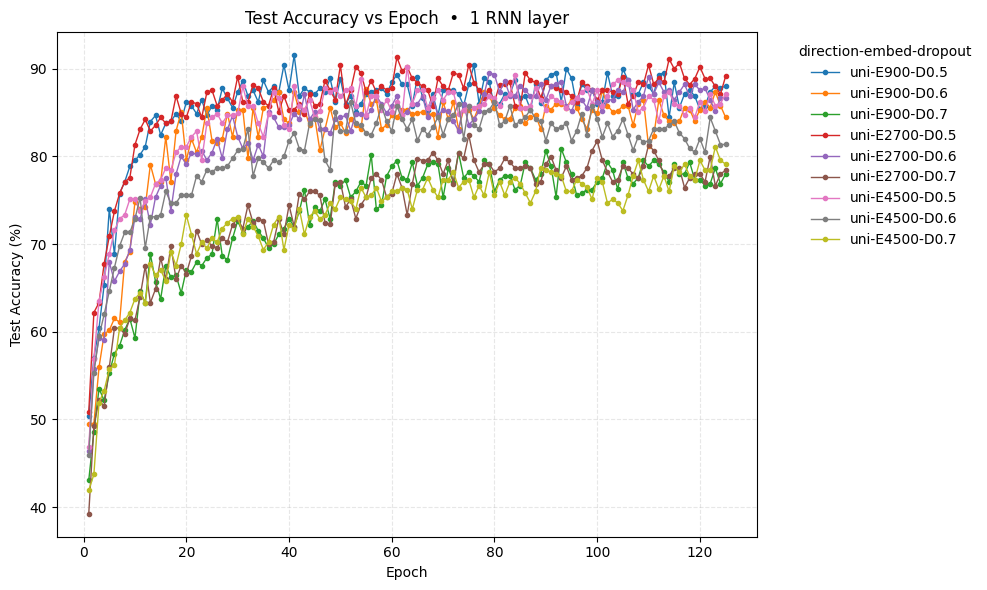

✅  Saved: /home/mustard7385/bd3/twitter-sentiment-analysis/model7/test_acc_vs_epoch_layers1.png


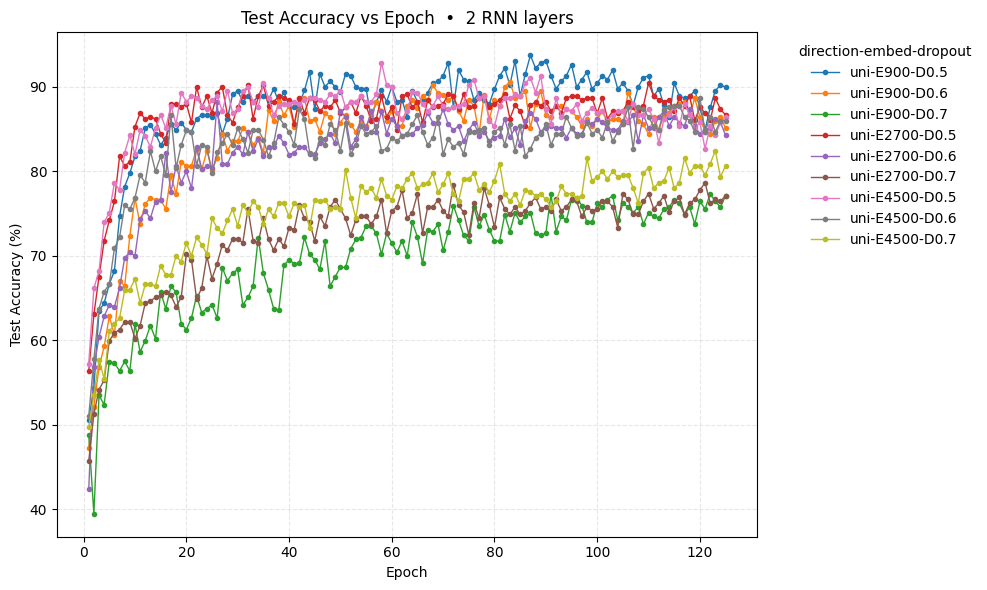

✅  Saved: /home/mustard7385/bd3/twitter-sentiment-analysis/model7/test_acc_vs_epoch_layers2.png


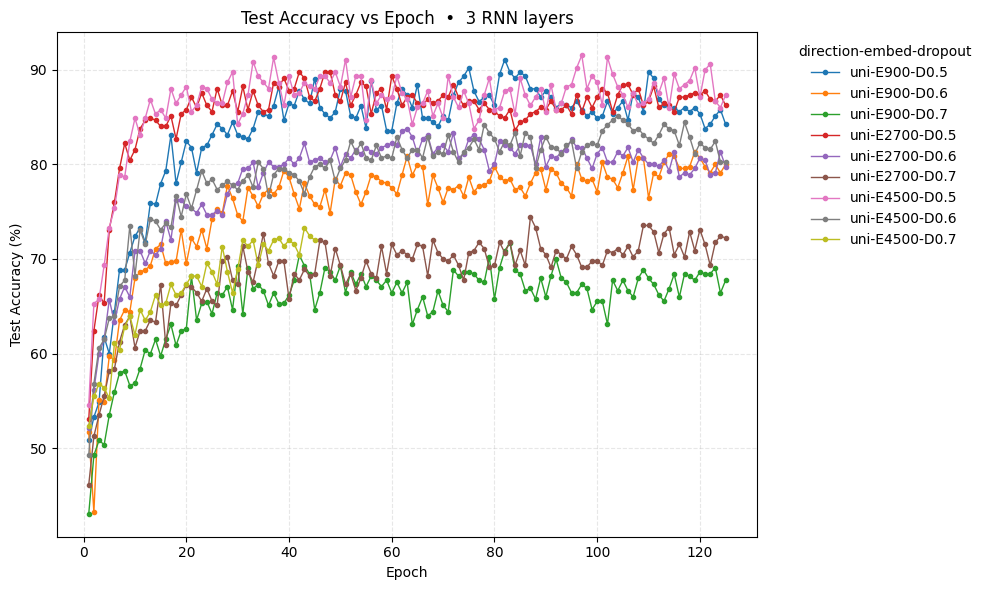

✅  Saved: /home/mustard7385/bd3/twitter-sentiment-analysis/model7/test_acc_vs_epoch_layers3.png


In [13]:
# ---------------------------------------------------------------------
# 3️⃣  Five plots, one for each "layers" value ------------------------
# ---------------------------------------------------------------------
import matplotlib.pyplot as plt
from pathlib import Path

layer_values = sorted(df_filtered["layers"].unique())       

for layers in layer_values:
    df_l = df_filtered[df_filtered["layers"] == layers]

    # ── create the line-plot for this layer count ────────────────────
    plt.figure(figsize=(10, 6))

    for (bidir, emb_dim, dropout), g in df_l.groupby(["bidir", "emb_dim", "dropout"]):
        direction = "bi" if bidir else "uni"
        label = f"{direction}-E{emb_dim}-D{dropout}"
        plt.plot(
            g["Epoch"],
            g["TestAcc"] * 100,          # convert 0–1 ➜ percentage
            marker=".",
            linewidth=1,
            label=label,
        )

    plt.title(f"Test Accuracy vs Epoch  •  {layers} RNN layer{'s' if layers>1 else ''}")
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(
        title="direction-embed-dropout",
        bbox_to_anchor=(1.04, 1), loc="upper left",
        frameon=False,
    )
    plt.tight_layout()

    # ── save and (optionally) show ───────────────────────────────────
    fig_path = Path(f"test_acc_vs_epoch_layers{layers}.png")
    plt.savefig(fig_path, dpi=300)
    plt.show()

    print(f"✅  Saved: {fig_path.resolve()}")

In [15]:
from pathlib import Path
import matplotlib.pyplot as plt

# location for the per-configuration files
metrics_root = Path("./metrics")
metrics_root.mkdir(exist_ok=True)

# iterate over every unique hyper-parameter combination
grouped = df_filtered.groupby(["layers", "bidir", "emb_dim", "dropout"], sort=False)

for (layers, bidir, emb_dim, dropout), g in grouped:
    direction = "bidir" if bidir else "uni"
    fname = f"metrics_layers{layers}_{direction}_emb{emb_dim}_drop{dropout}.csv"
    (metrics_root / fname).write_text(             # fast save w/o index
        g.sort_values("Epoch").to_csv(index=False)
    )

print(f"✅  Wrote {len(grouped)} files to {metrics_root.resolve()}")

✅  Wrote 27 files to /home/mustard7385/bd3/twitter-sentiment-analysis/model7/metrics


In [22]:
# -------------------------------------------------------------
# Columns that define one hyper-parameter configuration
# -------------------------------------------------------------
param_cols = ["layers", "bidir", "emb_dim", "dropout"]

# -------------------------------------------------------------
# 1) keep rows with TestAcc > 0.46
# 2) keep only the hyper-parameter columns
# 3) drop duplicate configurations
# 4) reset the index (optional, just for neat printing / saving)
# -------------------------------------------------------------
good_param_sets = (
    best_valid_rows                      # or df_filtered, if you prefer
        .loc[best_valid_rows["TestAcc"] > 0.46, param_cols]
        .drop_duplicates()
        .reset_index(drop=True)
)

print(good_param_sets.to_string(index=False))

# If you want to save it:
# good_param_sets.to_csv("good_param_sets.csv", index=False)

 layers  bidir  emb_dim  dropout
      2   True     3600      0.7
      4   True     1800      0.7
      4   True     3600      0.7
      2   True     2700      0.7
      3   True     4500      0.7


In [23]:
# ---------------------------------------------------------------
# 0. Hyper-parameter grid we are interested in
# ---------------------------------------------------------------
layer_options   = [2, 3, 4]
bidir_options   = [True]
embedding_dims  = [1800, 2700, 3600, 4500]
dropout_options = [0.7]

# ---------------------------------------------------------------
# 1. Keep only the runs that belong to that grid
# ---------------------------------------------------------------
mask = (
    df_filtered["layers"].isin(layer_options)   &
    df_filtered["bidir"].isin(bidir_options)    &
    df_filtered["emb_dim"].isin(embedding_dims) &
    df_filtered["dropout"].isin(dropout_options)
)
df_sub = df_filtered.loc[mask]

# ---------------------------------------------------------------
# 2. Per run → retain the LAST 50 epochs (or fewer if run is short)
# ---------------------------------------------------------------
df_last50 = (
    df_sub
      .sort_values(["layers", "bidir", "emb_dim", "dropout", "Epoch"])
      .groupby(["layers", "bidir", "emb_dim", "dropout"], as_index=False, group_keys=False)
      .tail(50)                  # keep the 50 largest Epoch numbers of each group
)

# ---------------------------------------------------------------
# 3. Compute the mean TestAcc on those epochs
# ---------------------------------------------------------------
mean_test_acc = (
    df_last50
      .groupby(["layers", "bidir", "emb_dim", "dropout"], as_index=False)
      .agg(MeanTestAcc=("TestAcc", "mean"),
           EpochCnt   =("Epoch",   "nunique"),   # how many epochs actually used
           FirstEpoch =("Epoch",   "min"),       # first epoch kept (optional)
           LastEpoch  =("Epoch",   "max"))       # last  epoch kept (optional)
      .sort_values("MeanTestAcc", ascending=False)
)

# ---------------------------------------------------------------
# 4. Show / export
# ---------------------------------------------------------------
cols_to_show = ["MeanTestAcc", "EpochCnt", "FirstEpoch", "LastEpoch",
                "layers", "bidir", "emb_dim", "dropout"]
print(mean_test_acc[cols_to_show].to_string(index=False))

# Optional: save to disk
# mean_test_acc[cols_to_show].to_csv("mean_test_acc_last50.csv", index=False)

 MeanTestAcc  EpochCnt  FirstEpoch  LastEpoch  layers  bidir  emb_dim  dropout
    0.439950        50          76        125       4   True     3600      0.7
    0.434474        50          76        125       4   True     1800      0.7
    0.426802        50          76        125       2   True     2700      0.7
    0.425330        50          76        125       2   True     4500      0.7
    0.422006        50          76        125       2   True     1800      0.7
    0.421928        50          76        125       3   True     4500      0.7
    0.421052        50          76        125       4   True     2700      0.7
    0.420760        50          76        125       2   True     3600      0.7
    0.414538        50          76        125       3   True     2700      0.7
    0.404500        50          76        125       4   True     4500      0.7
    0.403466        50          76        125       3   True     3600      0.7
    0.401646        50          76        125       

In [1]:
import pandas as pd
from pathlib import Path
import re

root = Path("./lstm_traget2")
csv_files = root.rglob("*.csv")  # all CSVs underneath ./lstm

# Parent-folder name looks like: LSTM_layers{N}_{bidir|uni}_emb{D}_drop{P}
pat = re.compile(r"LSTM_layers(\d+)_(bidir|uni)_emb(\d+)_drop([0-9.]+)")

# --- generic helpers ----------------------------------------------------------
def _after_equals(x: str) -> str:
    """Take the substring after '=' (if '=' is present) and remove leading/trailing blanks."""
    return str(x).split("=", 1)[-1].strip()

def pct_to_float(x):
    return float(_after_equals(x).rstrip("%")) / 100

def num_to_float(x):
    return float(_after_equals(x))

def num_to_int(x):
    return int(_after_equals(x))

# ------------------------------------------------------------------------------

def read_and_annotate(csv_path: Path) -> pd.DataFrame:
    # Read the CSV, skipping summary lines and converting columns
    df = pd.read_csv(
        csv_path,
        skipinitialspace=True,         # ignore spaces after commas
        comment='B',                   # skip lines starting with 'B' (BestLoss/BestAcc summaries)
        converters={
            "TrainLoss": num_to_float,

            "TestLoss":  num_to_float,
            "TrainAcc":  pct_to_float,

            "TestAcc":   pct_to_float,
            "Epoch":     num_to_int,
            "Min":       num_to_int,   # minutes are integers
            "Sec":       num_to_float  # seconds may be fractional, parse as float
        }
    )

    # Extract hyper-parameters from the folder name using regex
    m = pat.fullmatch(csv_path.parent.name)
    if not m:
        raise ValueError(f"Folder name {csv_path.parent.name} does not match pattern")
    n_layers, direction, emb_dim, dropout = m.groups()

    # Add hyper-parameter columns to the DataFrame
    df["layers"]  = int(n_layers)
    df["bidir"]   = (direction == "bidir")
    df["emb_dim"] = int(emb_dim)
    df["dropout"] = float(dropout)

    return df

# Build the big tidy DataFrame by concatenating all annotated DataFrames
df_all = pd.concat([read_and_annotate(p) for p in csv_files], ignore_index=True)

# (Optional) set a multi-index for easier slicing of hyper-parameters and sort it
df_all = df_all.set_index(["layers", "bidir", "emb_dim", "dropout", "Epoch"]).sort_index()

print(df_all.head())

# Reset index to get columns back (if you set a multi-index before)
df_all_reset = df_all.reset_index()

# Select only the columns of interest: hyperparameters, Epoch, and validation/test metrics
df_filtered = df_all_reset[[
    "layers", "bidir", "emb_dim", "dropout", "Epoch","TrainLoss","TrainAcc",
      "TestLoss", "TestAcc"
]]
layer_options = [1,2]
bidir_options = [True]  
embedding_dims = [900,2700,4500]
dropout_options = [0.5,0.6,0.7]

                                    TrainLoss  TrainAcc  TestLoss  TestAcc  \
layers bidir emb_dim dropout Epoch                                           
1      True  900     0.5     1         1.1087    0.5260    0.8557   0.6708   
                             2         0.8257    0.6695    0.6050   0.8019   
                             3         0.6443    0.7487    0.4518   0.8755   
                             4         0.5273    0.7990    0.3843   0.8887   
                             5         0.4543    0.8278    0.3128   0.8954   

                                    Min   Sec  
layers bidir emb_dim dropout Epoch             
1      True  900     0.5     1        0  13.0  
                             2        0  13.0  
                             3        0  13.0  
                             4        0   8.0  
                             5        0   5.0  


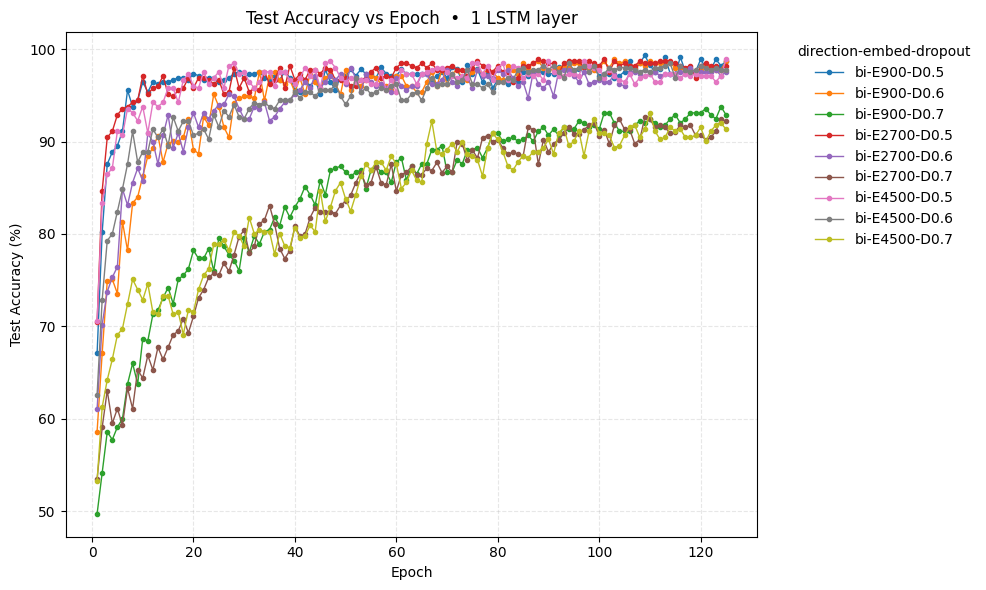

✅  Saved: /home/mustard7385/bd3/twitter-sentiment-analysis/model2/test_acc_vs_epoch_layers1.png


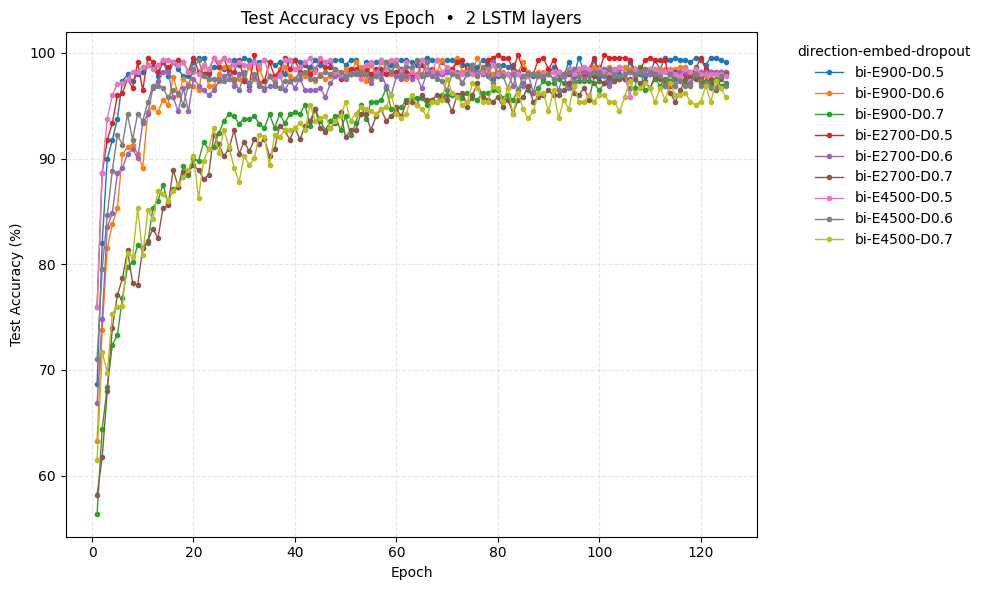

✅  Saved: /home/mustard7385/bd3/twitter-sentiment-analysis/model2/test_acc_vs_epoch_layers2.png


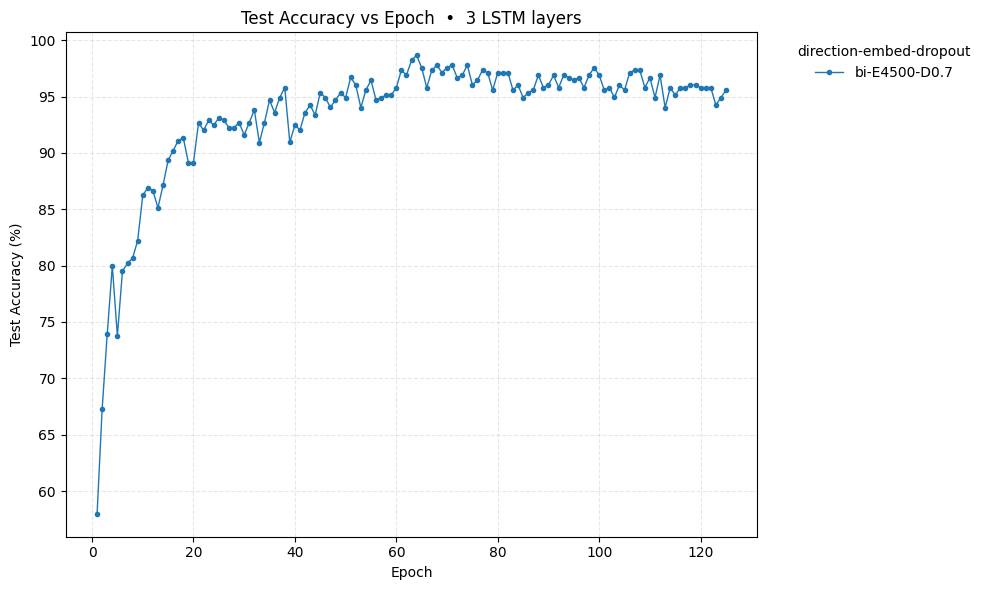

✅  Saved: /home/mustard7385/bd3/twitter-sentiment-analysis/model2/test_acc_vs_epoch_layers3.png


In [2]:
# ---------------------------------------------------------------------
# 3️⃣  Five plots, one for each "layers" value ------------------------
# ---------------------------------------------------------------------
import matplotlib.pyplot as plt
from pathlib import Path

layer_values = sorted(df_filtered["layers"].unique())       

for layers in layer_values:
    df_l = df_filtered[df_filtered["layers"] == layers]

    # ── create the line-plot for this layer count ────────────────────
    plt.figure(figsize=(10, 6))

    for (bidir, emb_dim, dropout), g in df_l.groupby(["bidir", "emb_dim", "dropout"]):
        direction = "bi" if bidir else "uni"
        label = f"{direction}-E{emb_dim}-D{dropout}"
        plt.plot(
            g["Epoch"],
            g["TestAcc"] * 100,          # convert 0–1 ➜ percentage
            marker=".",
            linewidth=1,
            label=label,
        )

    plt.title(f"Test Accuracy vs Epoch  •  {layers} LSTM layer{'s' if layers>1 else ''}")
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy (%)")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.legend(
        title="direction-embed-dropout",
        bbox_to_anchor=(1.04, 1), loc="upper left",
        frameon=False,
    )
    plt.tight_layout()

    # ── save and (optionally) show ───────────────────────────────────
    fig_path = Path(f"test_acc_vs_epoch_layers{layers}.png")
    plt.savefig(fig_path, dpi=300)
    plt.show()

    print(f"✅  Saved: {fig_path.resolve()}")

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt

# location for the per-configuration files
metrics_root = Path("./metrics")
metrics_root.mkdir(exist_ok=True)

# iterate over every unique hyper-parameter combination
grouped = df_filtered.groupby(["layers", "bidir", "emb_dim", "dropout"], sort=False)

for (layers, bidir, emb_dim, dropout), g in grouped:
    direction = "bidir" if bidir else "uni"
    fname = f"metrics_layers{layers}_{direction}_emb{emb_dim}_drop{dropout}.csv"
    (metrics_root / fname).write_text(             # fast save w/o index
        g.sort_values("Epoch").to_csv(index=False)
    )

print(f"✅  Wrote {len(grouped)} files to {metrics_root.resolve()}")

✅  Wrote 19 files to /home/mustard7385/bd3/twitter-sentiment-analysis/model2/metrics
